# Word Embeddings: Encoding Lexical Semantics





Two examples in this notebook are considered:

1.   N-Gram Language Modeling
2.   Continuous Bag-of-Words

Based on a notebook of Robert Guthrie.





Word embeddings are dense vectors of real numbers, one per word in your
vocabulary. In NLP, it is almost always the case that your features are
words! But how should you represent a word in a computer? You could
store its ascii character representation, but that only tells you what
the word *is*, it doesn't say much about what it *means* (you might be
able to derive its part of speech from its affixes, or properties from
its capitalization, but not much). Even more, in what sense could you
combine these representations? We often want dense outputs from our
neural networks, where the inputs are $|V|$ dimensional, where
$V$ is our vocabulary, but often the outputs are only a few
dimensional (if we are only predicting a handful of labels, for
instance). How do we get from a massive dimensional space to a smaller
dimensional space?

How about instead of ascii representations, we use a one-hot encoding?
That is, we represent the word $w$ by

\begin{align}\overbrace{\left[ 0, 0, \dots, 1, \dots, 0, 0 \right]}^\text{|V| elements}\end{align}

where the 1 is in a location unique to $w$. Any other word will
have a 1 in some other location, and a 0 everywhere else.

There is an enormous drawback to this representation, besides just how
huge it is. It basically treats all words as independent entities with
no relation to each other. What we really want is some notion of
*similarity* between words. Why? Let's see an example.

Suppose we are building a language model. Suppose we have seen the
sentences

* The mathematician ran to the store.
* The physicist ran to the store.
* The mathematician solved the open problem.

in our training data. Now suppose we get a new sentence never before
seen in our training data:

* The physicist solved the open problem.

Our language model might do OK on this sentence, but wouldn't it be much
better if we could use the following two facts:

* We have seen  mathematician and physicist in the same role in a sentence. Somehow they
  have a semantic relation.
* We have seen mathematician in the same role  in this new unseen sentence
  as we are now seeing physicist.

and then infer that physicist is actually a good fit in the new unseen
sentence? This is what we mean by a notion of similarity: we mean
*semantic similarity*, not simply having similar orthographic
representations. It is a technique to combat the sparsity of linguistic
data, by connecting the dots between what we have seen and what we
haven't. This example of course relies on a fundamental linguistic
assumption: that words appearing in similar contexts are related to each
other semantically. This is called the [distributional
hypothesis](https://en.wikipedia.org/wiki/Distributional_semantics).

## Getting Dense Word Embeddings

How can we solve this problem? That is, how could we actually encode
semantic similarity in words? Maybe we think up some semantic
attributes. For example, we see that both mathematicians and physicists
can run, so maybe we give these words a high score for the "is able to
run" semantic attribute. Think of some other attributes, and imagine
what you might score some common words on those attributes.

If each attribute is a dimension, then we might give each word a vector,
like this:

$$
q_\text{mathematician} = \left[ \overbrace{2.3}^\text{can run},
   \overbrace{9.4}^\text{likes coffee}, \overbrace{-5.5}^\text{majored in Physics}, \dots \right]
$$

$$
q_\text{physicist} = \left[ \overbrace{2.5}^\text{can run},
   \overbrace{9.1}^\text{likes coffee}, \overbrace{6.4}^\text{majored in Physics}, \dots \right]
$$

Then we can get a measure of similarity between these words by doing:
$$
\text{Similarity}(\text{physicist}, \text{mathematician}) = q_\text{physicist} \cdot q_\text{mathematician}
$$

Although it is more common to normalize by the lengths:

$$
\text{Similarity}(\text{physicist}, \text{mathematician}) = \frac{q_\text{physicist} \cdot q_\text{mathematician}}
   {\| q_\text{physicist} \| \| q_\text{mathematician} \|} = \cos (\phi)
$$
where $\phi$ is the angle between the two vectors. That way,
extremely similar words (words whose embeddings point in the same
direction) will have similarity 1. Extremely dissimilar words should
have similarity -1.


You can think of the sparse one-hot vectors from the beginning of this
section as a special case of these new vectors we have defined, where
each word basically has similarity 0, and we gave each word some unique
semantic attribute. These new vectors are *dense*, which is to say their
entries are (typically) non-zero.

But these new vectors are a big pain: you could think of thousands of
different semantic attributes that might be relevant to determining
similarity, and how on earth would you set the values of the different
attributes? Central to the idea of deep learning is that the neural
network learns representations of the features, rather than requiring
the programmer to design them herself. So why not just let the word
embeddings be parameters in our model, and then be updated during
training? This is exactly what we will do. We will have some *latent
semantic attributes* that the network can, in principle, learn. Note
that the word embeddings will probably not be interpretable. That is,
although with our hand-crafted vectors above we can see that
mathematicians and physicists are similar in that they both like coffee,
if we allow a neural network to learn the embeddings and see that both
mathematicians and physicists have a large value in the second
dimension, it is not clear what that means. They are similar in some
latent semantic dimension, but this probably has no interpretation to
us.


In summary, **word embeddings are a representation of the *semantics* of
a word, efficiently encoding semantic information that might be relevant
to the task at hand**. You can embed other things too: part of speech
tags, parse trees, anything! The idea of feature embeddings is central
to the field.

## Word Embeddings in Pytorch

Similar to how we defined a unique index for each word when
making one-hot vectors, we also need to define an index for each word
when using embeddings. These will be keys into a lookup table. That is,
embeddings are stored as a $|V| \times D$ matrix, where $D$
is the dimensionality of the embeddings, such that the word assigned
index $i$ has its embedding stored in the $i$'th row of the
matrix. In all of my code, the mapping from words to indices is a
dictionary named word\_to\_ix.

The module that allows you to use embeddings is torch.nn.Embedding,
which takes two arguments: the vocabulary size, and the dimensionality
of the embeddings.

To index into this table, you must use torch.LongTensor (since the
indices are integers, not floats).

In [0]:
%matplotlib inline

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [0]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward>)


In [0]:
print(lookup_tensor)

tensor([0])


In [0]:
[word_to_ix["hello"]]

[0]

## First Example: N-Gram Language Modeling


Recall that in an n-gram language model, given a sequence of words
$w$, we want to compute
$$
P(w_i | w_{i-1}, w_{i-2}, \dots, w_{i-n+1} )
$$
where $w_i$ is the ith word of the sequence.

In this example, we will compute the loss function on some training
examples and update the parameters with backpropagation.





In [0]:

# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 5, just so you can see what they look like
print(trigrams[:5])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}

print(word_to_ix)

[(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege'), (['shall', 'besiege'], 'thy'), (['besiege', 'thy'], 'brow,')]
{'eyes,': 0, 'all-eating': 1, 'And': 2, 'weed': 3, "'This": 4, 'Where': 5, 'sunken': 6, 'thine': 7, 'within': 8, 'Were': 9, 'Thy': 10, 'count,': 11, 'Will': 12, 'cold.': 13, 'Proving': 14, 'thine!': 15, 'praise.': 16, 'brow,': 17, 'it': 18, 'How': 19, 'more': 20, 'child': 21, 'trenches': 22, 'the': 23, 'If': 24, 'days;': 25, 'be': 26, 'old': 27, 'see': 28, 'in': 29, 'so': 30, "excuse,'": 31, 'new': 32, 'succession': 33, 'use,': 34, 'Shall': 35, "deserv'd": 36, 'own': 37, 'thy': 38, 'asked,': 39, 'my': 40, 'thou': 41, "feel'st": 42, 'field,': 43, 'couldst': 44, 'answer': 45, 'a': 46, 'thriftless': 47, "totter'd": 48, 'worth': 49, 'deep': 50, 'made': 51, 'his': 52, 'make': 53, 'sum': 54, 'shame,': 55, 'mine': 56, 'forty': 57, 'when': 58, 'an': 59, 'old,': 60, 'dig': 61, 'praise': 62, 'of': 63, 'Then': 64, 'were': 65, 'gazed': 6

In [0]:
print(vocab)

{'eyes,', 'all-eating', 'And', 'weed', "'This", 'Where', 'sunken', 'thine', 'within', 'Were', 'Thy', 'count,', 'Will', 'cold.', 'Proving', 'thine!', 'praise.', 'brow,', 'it', 'How', 'more', 'child', 'trenches', 'the', 'If', 'days;', 'be', 'old', 'see', 'in', 'so', "excuse,'", 'new', 'succession', 'use,', 'Shall', "deserv'd", 'own', 'thy', 'asked,', 'my', 'thou', "feel'st", 'field,', 'couldst', 'answer', 'a', 'thriftless', "totter'd", 'worth', 'deep', 'made', 'his', 'make', 'sum', 'shame,', 'mine', 'forty', 'when', 'an', 'old,', 'dig', 'praise', 'of', 'Then', 'were', 'gazed', "youth's", 'now,', 'proud', 'art', 'all', 'and', 'much', 'small', 'shall', 'say,', "beauty's", 'beauty', 'When', 'lusty', 'winters', 'where', 'lies,', 'To', 'treasure', 'warm', 'blood', 'livery', 'This', 'besiege', 'on', 'held:', 'to', 'by', 'fair', 'being'}


### Question: what is the role of "nn.Embedding"?

In [0]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10

class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
    print(total_loss)
# print(losses)  # The loss decreased every iteration over the training data!


523.669487953186
521.2589163780212
518.8642108440399
516.4833686351776
514.1160209178925
511.7611951828003
509.41855216026306
507.0860333442688
504.7639615535736
502.4516885280609


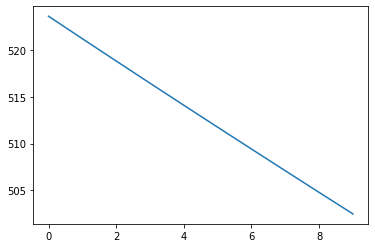

In [0]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [0]:
print(context)
print(context_idxs)

["feel'st", 'it']
tensor([42, 18])


## Second Example: Continuous Bag-of-Words


The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep
learning. It is a model that tries to predict words given the context of
a few words before and a few words after the target word. This is
distinct from language modeling, since CBOW is not sequential and does
not have to be probabilistic. Typcially, CBOW is used to quickly train
word embeddings, and these embeddings are used to initialize the
embeddings of some more complicated model. Usually, this is referred to
as *pretraining embeddings*. It almost always helps performance a couple
of percent.

The CBOW model is as follows. Given a target word $w_i$ and an
$N$ context window on each side, $w_{i-1}, \dots, w_{i-N}$
and $w_{i+1}, \dots, w_{i+N}$, referring to all context words
collectively as $C$, CBOW tries to minimize

\begin{align}-\log p(w_i | C) = -\log \text{Softmax}(A(\sum_{w \in C} q_w) + b)\end{align}

where $q_w$ is the embedding for word $w$.



### Question: what is the role of "word_to_ix" and "ix_to_word"?

In [0]:
import torch
import torch.nn as nn
import numpy as np

def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

def get_index_of_max(input):
    index = 0
    for i in range(1, len(input)):
        if input[i] > input[index]:
            index = i 
    return index

def get_max_prob_result(input, ix_to_word):
    return ix_to_word[get_index_of_max(input)]


CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMDEDDING_DIM = 100

word_to_ix = {}
ix_to_word = {}

raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()


# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)
print(vocab_size)

for i, word in enumerate(vocab):
    word_to_ix[word] = i
    ix_to_word[i] = word



49


In [0]:
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
    
    
print(context)    

['the', 'computer', 'our', 'spells.']


Class CBOW

### Question: what is the difference between the CBOW architecture coded in the following CBOW class and the CBOW architecture described in the lecture?

In [0]:
class CBOW(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.linear1 = nn.Linear(embedding_dim, 128)

        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)

        self.activation_function2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_embedding(self, word):
        word = torch.LongTensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)





Train the CBOW model

In [0]:
model = CBOW(vocab_size, EMDEDDING_DIM)

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)


for epoch in range(50):
    total_loss = 0
    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)  
        model.zero_grad()
        log_probs = model(context_vector)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        loss.backward()
        optimizer.step()

        total_loss += loss.data
    # print(total_loss)


Test the model

In [0]:
# ====================== TEST
context = ['People','create','to', 'direct']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector).data.numpy()
print('Raw text: {}\n'.format(' '.join(raw_text)))
print('Context: {}\n'.format(context))
print('Prediction: {}'.format(get_max_prob_result(a[0], ix_to_word)))

Raw text: We are about to study the idea of a computational process. Computational processes are abstract beings that inhabit computers. As they evolve, processes manipulate other abstract things called data. The evolution of a process is directed by a pattern of rules called a program. People create programs to direct processes. In effect, we conjure the spirits of the computer with our spells.

Context: ['People', 'create', 'to', 'direct']

Prediction: programs


### Question: How do we interpret the output "a" of "model"?

In [0]:
print(a) # probability for each word in the dictionnary

[[-3.540162   -5.3051496  -7.3224177  -6.7068934  -7.2577095  -7.3523803
  -6.508641   -5.656164   -6.3414683  -6.5088496  -2.584711   -0.29340163
  -6.416279   -5.710873   -6.2944503  -4.855522   -5.68413    -7.6347494
  -6.480114   -8.833589   -6.992215   -6.3129086  -7.1490397  -6.5000124
  -7.0352798  -6.8614683  -6.6984334  -6.2907367  -5.0783186  -6.4795265
  -7.35152    -7.3280973  -5.682646   -7.4569225  -4.1325297  -5.5048227
  -6.4989944  -4.274961   -4.004018   -5.5900717  -5.8518147  -6.2753406
  -4.837149   -6.813744   -5.4061747  -5.587881   -5.739819   -5.253447
  -6.104052  ]]


### Question: what is the word embedding of the word "People"?

In [0]:
# Complete this cell to give the word vector of "People"
model.get_word_embedding("People").shape

torch.Size([1, 100])

### Question: in the lecture, the CBOW model can propose at least two kinds of embedding for a given word. Which one is used in this code?

here we use a DNN with Relu

### Question: count all the parameters of the model. Is the embedding matrix learned during the training step?

In [0]:
# Count the parameters in this celle
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

24149


In [0]:
49*100+100*128+128*49+128+49

24149

In [0]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %shell  %store  %sx  %system  %tb  %tensorflow_version  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%bigquery  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl 